<h1 style="text-align: center;">DATA 255 - Fall24 - Group Project</h1>

<h2 style="text-align: center;"> Pneumonia Detection using chest X-Ray and Deep Learning Technologies

## 1. Importing necessary libraries

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import transforms
import matplotlib.pyplot as plt
import shutil
import random
from torchvision import datasets
from PIL import Image
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report

## 2. Loading and Exploring the data

#### <b> 2.1. Importing train, Validation and test Dataset, and exploring the classes of images

In [1]:
# Define paths
base_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

# Define transformations for the images
transform = transforms.Compose([
    transforms.Resize((150, 150)),  # Resize to 150x150
    transforms.ToTensor(),         # Convert image to PyTorch tensor
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize to range [-1, 1]
])

# Load the datasets
train_dataset = datasets.ImageFolder(train_dir, transform=transform)
val_dataset = datasets.ImageFolder(val_dir, transform=transform)
test_dataset = datasets.ImageFolder(test_dir, transform=transform)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Class mappings (optional, to verify classes)
class_names = train_dataset.classes
print("Class Names:", class_names)

Class Names: ['NORMAL', 'PNEUMONIA']


#### <b> 2.2. How many images present in the train, Validation and test Dataset

In [2]:
# Count images in each dataset
train_total = len(train_dataset)
val_total = len(val_dataset)
test_total = len(test_dataset)

# Calculate ratios
total_images = train_total + val_total + test_total
train_ratio = train_total / total_images
val_ratio = val_total / total_images
test_ratio = test_total / total_images

# Print results
print(f"Total Images: {total_images}")
print(f"Training Set: {train_total} images ({train_ratio:.2%} of total)")
print(f"Validation Set: {val_total} images ({val_ratio:.2%} of total)")
print(f"Test Set: {test_total} images ({test_ratio:.2%} of total)")

Total Images: 5856
Training Set: 5216 images (89.07% of total)
Validation Set: 16 images (0.27% of total)
Test Set: 624 images (10.66% of total)


#### Validation Set: Contains only 16 images, accounting for just 0.27% of the total dataset. This is unusually small for a validation set, which might lead to unreliable performance evaluation during training.

#### Here we see that the dataset split is not proper

#### <b> 2.3. Visually showing how many images present in the train, Validation and test Dataset

Train Class Distribution: {'NORMAL': 1341, 'PNEUMONIA': 3875}
Validation Class Distribution: {'NORMAL': 8, 'PNEUMONIA': 8}
Test Class Distribution: {'NORMAL': 234, 'PNEUMONIA': 390}


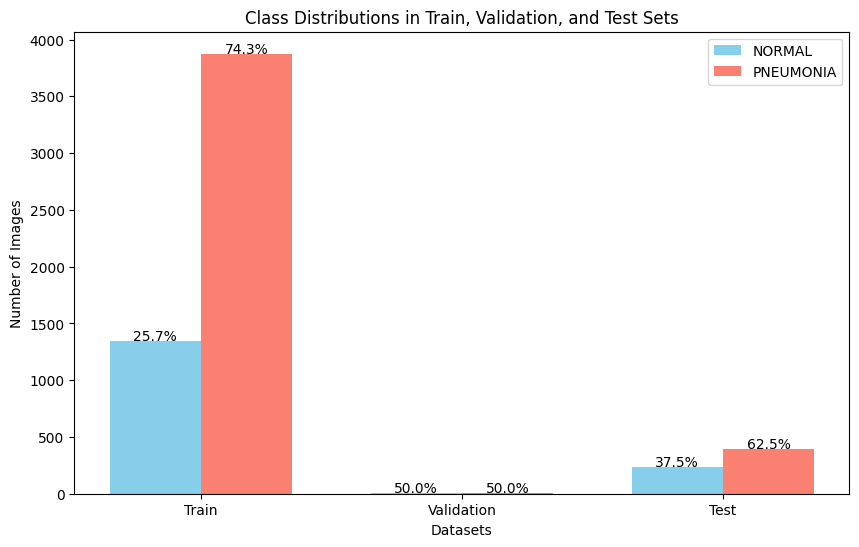

In [3]:
# Count images for each class
def count_images_per_class(dataset):
    class_counts = {class_name: 0 for class_name in dataset.classes}
    for _, label in dataset:
        class_name = dataset.classes[label]
        class_counts[class_name] += 1
    return class_counts

# Get class distributions
train_counts = count_images_per_class(train_dataset)
val_counts = count_images_per_class(val_dataset)
test_counts = count_images_per_class(test_dataset)

# Print distributions
print("Train Class Distribution:", train_counts)
print("Validation Class Distribution:", val_counts)
print("Test Class Distribution:", test_counts)

# Visualization
datasets_names = ['Train', 'Validation', 'Test']
class_labels = train_dataset.classes  # Classes from ImageFolder

# Prepare data for plotting
data = [
    [train_counts[class_labels[0]], train_counts[class_labels[1]]],
    [val_counts[class_labels[0]], val_counts[class_labels[1]]],
    [test_counts[class_labels[0]], test_counts[class_labels[1]]],
]

# Calculate total images in each dataset
totals = [sum(d) for d in data]

# Plot bar chart
x = range(len(datasets_names))
bar_width = 0.35

plt.figure(figsize=(10, 6))
bars1 = plt.bar(x, [d[0] for d in data], width=bar_width, label=class_labels[0], color='skyblue')
bars2 = plt.bar([i + bar_width for i in x], [d[1] for d in data], width=bar_width, label=class_labels[1], color='salmon')

# Add percentage labels on top of the bars
for i, bars in enumerate([bars1, bars2]):  # Loop through NORMAL and PNEUMONIA bars
    for bar, count in zip(bars, [d[i] for d in data]):
        percent = (count / totals[bars.index(bar)]) * 100  # Calculate percentage
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 5, f'{percent:.1f}%', 
                 ha='center', fontsize=10)

# Add labels and title
plt.xlabel('Datasets')
plt.ylabel('Number of Images')
plt.title('Class Distributions in Train, Validation, and Test Sets')
plt.xticks([i + bar_width / 2 for i in x], datasets_names)
plt.legend()
plt.show()


### Here we see that the Classes are balanced only in validation dataset but highly imbalanced in Train and Test dataset. However, the small size of the validation set makes it unreliable for evaluating class-specific performance or overall validation accuracy.

### Training Set: The PNEUMONIA class has significantly more samples (3875) than the NORMAL class (1341). This imbalance may cause the model to become biased toward predicting PNEUMONIA more often, leading to poor generalization for the NORMAL class

## 3. Preprocessing the Data 

#### <b> 3.1. Data Redistribution for Chest X-Ray Pneumonia Dataset

In [4]:
# Paths to original directories
train_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray/train'
val_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray/val'
test_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray/test'

# New directories for redistributed data
base_dir = '/kaggle/working/chest_xray_redistributed'
train_new_dir = os.path.join(base_dir, 'train')
val_new_dir = os.path.join(base_dir, 'val')
test_new_dir = os.path.join(base_dir, 'test')

# Create new directories
os.makedirs(train_new_dir, exist_ok=True)
os.makedirs(val_new_dir, exist_ok=True)
os.makedirs(test_new_dir, exist_ok=True)

for cls in ['NORMAL', 'PNEUMONIA']:
    os.makedirs(os.path.join(train_new_dir, cls), exist_ok=True)
    os.makedirs(os.path.join(val_new_dir, cls), exist_ok=True)
    os.makedirs(os.path.join(test_new_dir, cls), exist_ok=True)

# Function to gather all images in a directory structure
def get_all_images(directory, class_name):
    full_path = os.path.join(directory, class_name)
    return [os.path.join(full_path, fname) for fname in os.listdir(full_path) if fname.endswith(('.png', '.jpg', '.jpeg'))]

# Gather images from the original directories
all_normal = get_all_images(train_dir, 'NORMAL') + get_all_images(val_dir, 'NORMAL') + get_all_images(test_dir, 'NORMAL')
all_pneumonia = get_all_images(train_dir, 'PNEUMONIA') + get_all_images(val_dir, 'PNEUMONIA') + get_all_images(test_dir, 'PNEUMONIA')

# Shuffle images for random distribution
random.shuffle(all_normal)
random.shuffle(all_pneumonia)

# Function to split data into train, validation, and test sets
def split_data(data, train_ratio, val_ratio):
    train_split = int(len(data) * train_ratio)
    val_split = int(len(data) * (train_ratio + val_ratio))
    return data[:train_split], data[train_split:val_split], data[val_split:]

# Split the data
train_normal, val_normal, test_normal = split_data(all_normal, 0.7, 0.15)
train_pneumonia, val_pneumonia, test_pneumonia = split_data(all_pneumonia, 0.7, 0.15)

# Function to copy files to target directory
def copy_files(file_list, target_dir):
    for file_path in file_list:
        shutil.copy(file_path, target_dir)

# Copy files to new directories
copy_files(train_normal, os.path.join(train_new_dir, 'NORMAL'))
copy_files(val_normal, os.path.join(val_new_dir, 'NORMAL'))
copy_files(test_normal, os.path.join(test_new_dir, 'NORMAL'))

copy_files(train_pneumonia, os.path.join(train_new_dir, 'PNEUMONIA'))
copy_files(val_pneumonia, os.path.join(val_new_dir, 'PNEUMONIA'))
copy_files(test_pneumonia, os.path.join(test_new_dir, 'PNEUMONIA'))

print("Data redistribution complete!")

Data redistribution complete!


#### <b> 3.2. Analyzing Redistributed Datasets

In [5]:
# Paths to redistributed data directories
redistributed_train_dir = '/kaggle/working/chest_xray_redistributed/train'
redistributed_val_dir = '/kaggle/working/chest_xray_redistributed/val'
redistributed_test_dir = '/kaggle/working/chest_xray_redistributed/test'

# Function to count images per class
def count_images_per_class(directory):
    dataset = datasets.ImageFolder(directory)
    class_counts = {class_name: 0 for class_name in dataset.classes}
    for _, label in dataset:
        class_name = dataset.classes[label]
        class_counts[class_name] += 1
    return class_counts

# Count images in redistributed datasets
redistributed_train_counts = count_images_per_class(redistributed_train_dir)
redistributed_val_counts = count_images_per_class(redistributed_val_dir)
redistributed_test_counts = count_images_per_class(redistributed_test_dir)

# Total images in redistributed datasets
total_images_redistributed = (
    sum(redistributed_train_counts.values()) +
    sum(redistributed_val_counts.values()) +
    sum(redistributed_test_counts.values())
)

# Calculate ratios
train_ratio_redistributed = sum(redistributed_train_counts.values()) / total_images_redistributed * 100
val_ratio_redistributed = sum(redistributed_val_counts.values()) / total_images_redistributed * 100
test_ratio_redistributed = sum(redistributed_test_counts.values()) / total_images_redistributed * 100

# Print ratios
print("Redistributed Data Ratios:")
print(f"Training Set: {sum(redistributed_train_counts.values())} images ({train_ratio_redistributed:.2f}% of total)")
print(f"Validation Set: {sum(redistributed_val_counts.values())} images ({val_ratio_redistributed:.2f}% of total)")
print(f"Test Set: {sum(redistributed_test_counts.values())} images ({test_ratio_redistributed:.2f}% of total)")

# Print class-wise distributions
print("\nClass-wise Distributions:")
print(f"Train Class Distribution: {redistributed_train_counts}")
print(f"Validation Class Distribution: {redistributed_val_counts}")
print(f"Test Class Distribution: {redistributed_test_counts}")

Redistributed Data Ratios:
Training Set: 4099 images (70.00% of total)
Validation Set: 878 images (14.99% of total)
Test Set: 879 images (15.01% of total)

Class-wise Distributions:
Train Class Distribution: {'NORMAL': 1108, 'PNEUMONIA': 2991}
Validation Class Distribution: {'NORMAL': 237, 'PNEUMONIA': 641}
Test Class Distribution: {'NORMAL': 238, 'PNEUMONIA': 641}


### You want to avoid the possibility of overfitting by using a too-small validation set. By allocating 15% for both validation and test sets, you ensure that both the validation and test sets are sufficiently large and representative of the entire dataset

### With 80:10:10 split, the model might overfit on the training set since the validation set is too small to give meaningful feedback

#### <b> 3.3. Visually showing how many images present in the train, Validation and test Redistributed Dataset

Train Class Distribution: {'NORMAL': 1108, 'PNEUMONIA': 2991}
Validation Class Distribution: {'NORMAL': 237, 'PNEUMONIA': 641}
Test Class Distribution: {'NORMAL': 238, 'PNEUMONIA': 641}


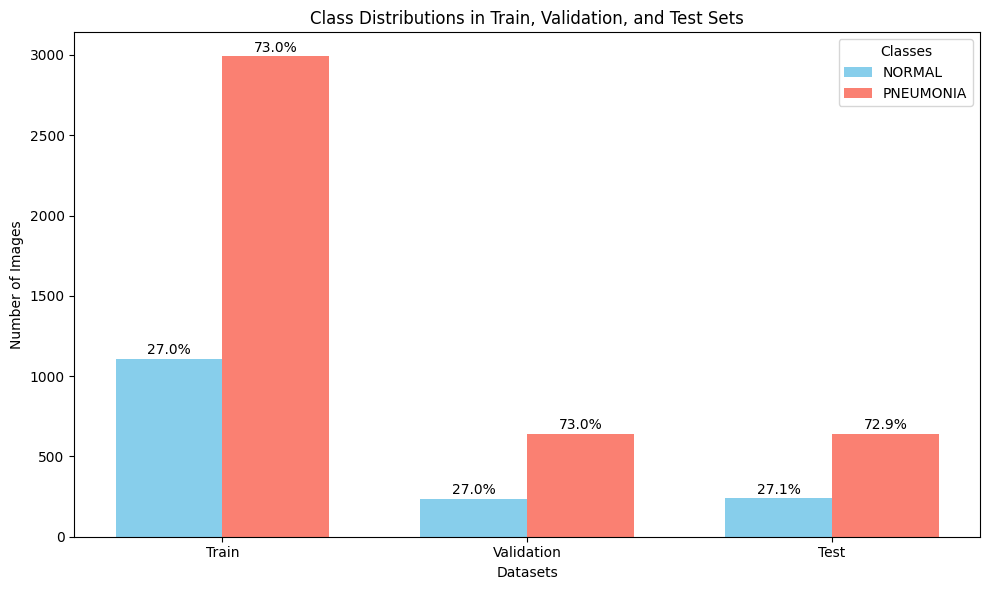

In [6]:
# Function to count images per class using PyTorch ImageFolder
def count_images_per_class(directory):
    dataset = datasets.ImageFolder(directory)
    class_counts = {class_name: 0 for class_name in dataset.classes}
    for _, label in dataset:
        class_name = dataset.classes[label]
        class_counts[class_name] += 1
    return class_counts

# Count images in redistributed datasets
redistributed_train_counts = count_images_per_class(redistributed_train_dir)
redistributed_val_counts = count_images_per_class(redistributed_val_dir)
redistributed_test_counts = count_images_per_class(redistributed_test_dir)

# Print class distributions
print("Train Class Distribution:", redistributed_train_counts)
print("Validation Class Distribution:", redistributed_val_counts)
print("Test Class Distribution:", redistributed_test_counts)

# Visualization
datasets = ['Train', 'Validation', 'Test']
class_labels = list(redistributed_train_counts.keys())  # Dynamically get class labels

# Prepare data for plotting
data = [
    [redistributed_train_counts[class_labels[0]], redistributed_train_counts[class_labels[1]]],
    [redistributed_val_counts[class_labels[0]], redistributed_val_counts[class_labels[1]]],
    [redistributed_test_counts[class_labels[0]], redistributed_test_counts[class_labels[1]]],
]

# Plot bar chart
x = range(len(datasets))
bar_width = 0.35

plt.figure(figsize=(10, 6))
bars1 = plt.bar(x, [d[0] for d in data], width=bar_width, label=class_labels[0], color='skyblue')
bars2 = plt.bar([i + bar_width for i in x], [d[1] for d in data], width=bar_width, label=class_labels[1], color='salmon')

# Add percentage labels on top of the bars
totals = [sum(d) for d in data]
for i, bars in enumerate([bars1, bars2]):  # Loop through class-wise bars
    for bar, count in zip(bars, [d[i] for d in data]):
        percent = (count / totals[bars.index(bar)]) * 100  # Calculate percentage
        # Place percentage labels clearly above the bars
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 10, f'{percent:.1f}%',
                 ha='center', fontsize=10, color='black', va='bottom')

# Add labels and title
plt.xlabel('Datasets')
plt.ylabel('Number of Images')
plt.title('Class Distributions in Train, Validation, and Test Sets')
plt.xticks([i + bar_width / 2 for i in x], datasets)
plt.legend(title="Classes")
plt.tight_layout()
plt.show()

## 4. Basic Data Exploration

#### <b> 4.1. Displaying Sample Images from Redistributed Dataset

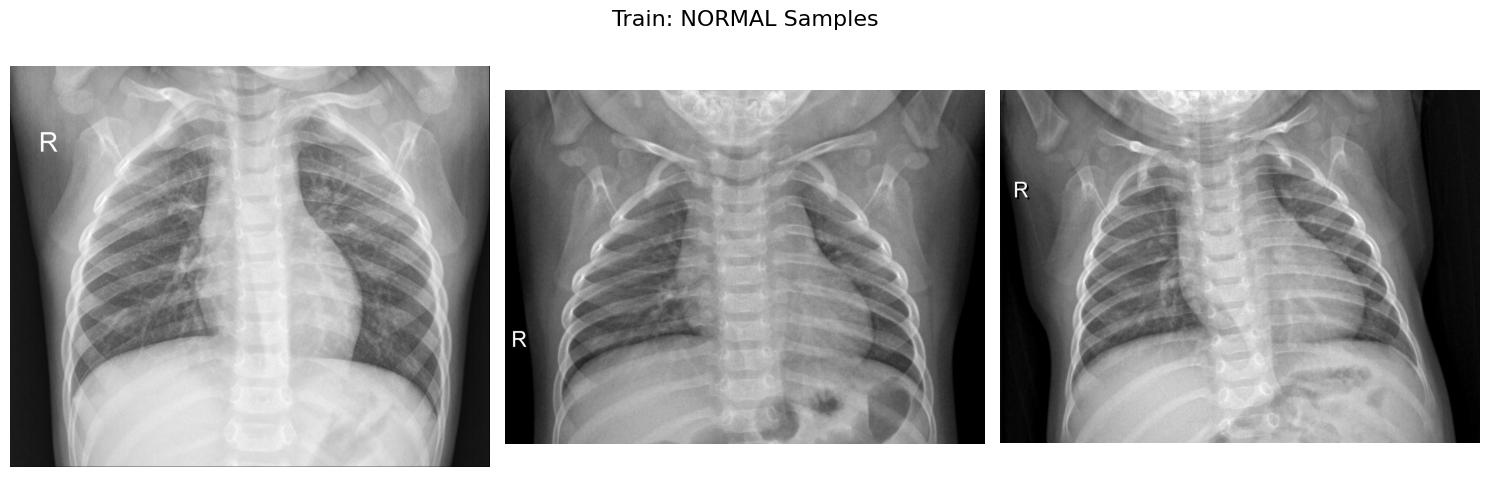

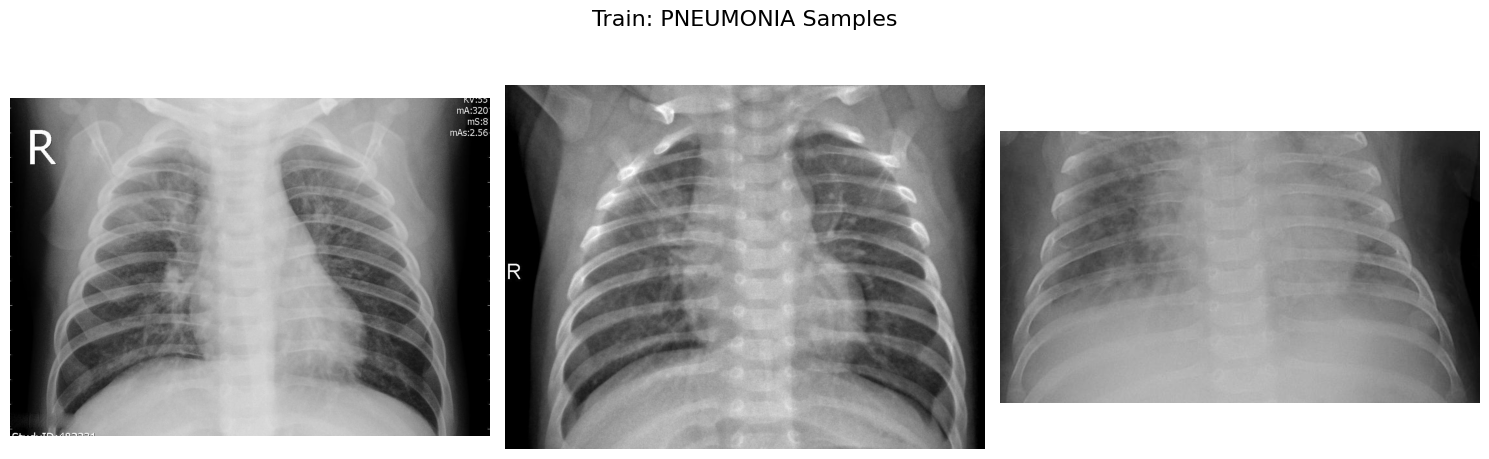

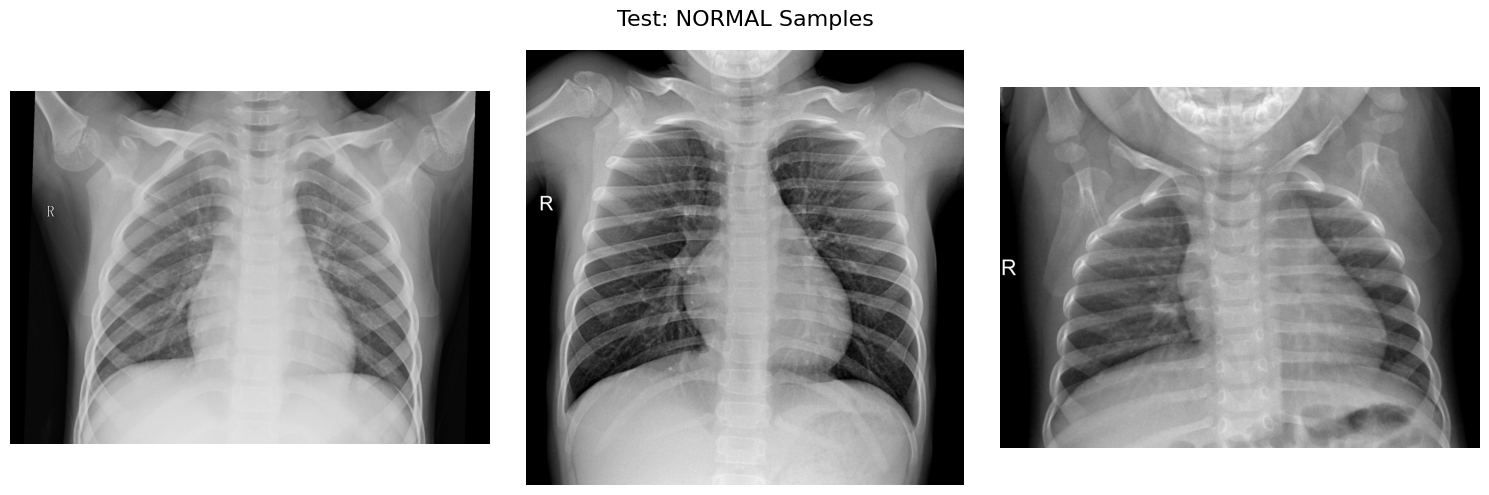

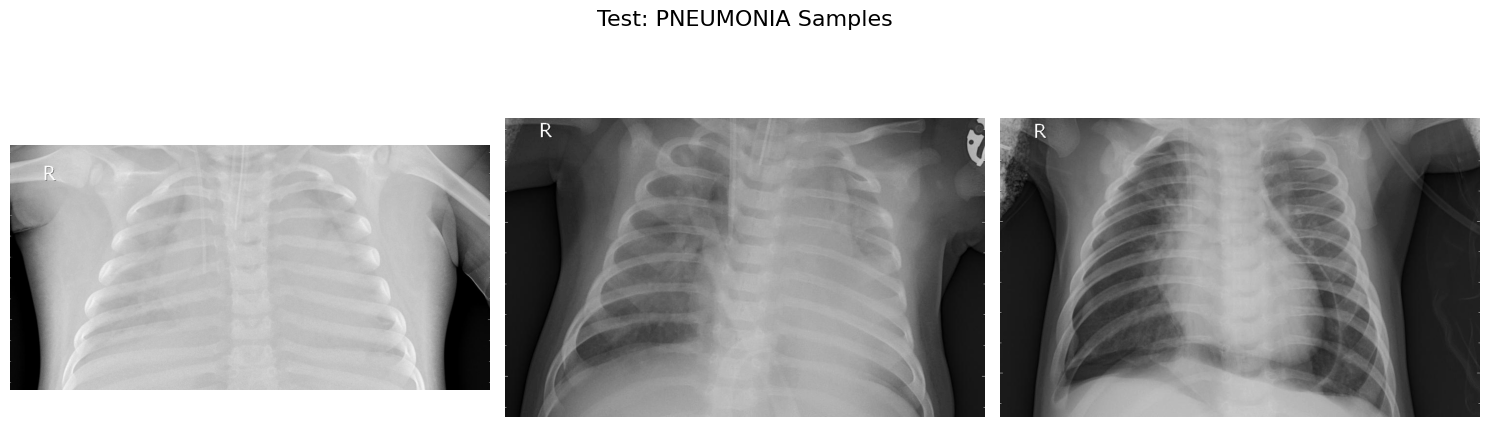

In [7]:
# Function to get image file paths from a specific class
def get_sample_images(directory, class_name, num_samples=3):
    class_dir = os.path.join(directory, class_name)
    image_files = os.listdir(class_dir)
    sample_files = image_files[:num_samples]  # Take the first few images
    return [os.path.join(class_dir, file) for file in sample_files]

# Get samples from train and test datasets
train_normal_samples = get_sample_images(redistributed_train_dir, 'NORMAL', 3)
train_pneumonia_samples = get_sample_images(redistributed_train_dir, 'PNEUMONIA', 3)
test_normal_samples = get_sample_images(redistributed_test_dir, 'NORMAL', 3)
test_pneumonia_samples = get_sample_images(redistributed_test_dir, 'PNEUMONIA', 3)

# Function to display images
def display_images(image_paths, title, rows=1, cols=3):
    plt.figure(figsize=(15, 5))
    for i, image_path in enumerate(image_paths):
        img = Image.open(image_path)
        plt.subplot(rows, cols, i + 1)
        plt.imshow(img, cmap='gray')
        plt.axis('off')
    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

# Display samples
display_images(train_normal_samples, "Train: NORMAL Samples")
display_images(train_pneumonia_samples, "Train: PNEUMONIA Samples")
display_images(test_normal_samples, "Test: NORMAL Samples")
display_images(test_pneumonia_samples, "Test: PNEUMONIA Samples")

#### <b> 4.2. Calculating Average Image Sizes for Dataset Classes

In [8]:
# Function to calculate average image sizes for classes
def get_image_sizes(directory):
    sizes = {}
    for cls in ['NORMAL', 'PNEUMONIA']:
        class_dir = os.path.join(directory, cls)
        image_sizes = []
        for img_name in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_name)
            with Image.open(img_path) as img:  # Open the image using PIL
                img_size = img.size  # Returns (width, height)
                image_sizes.append(img_size)
        
        # Calculate the average width and height for the class
        avg_width = sum([size[0] for size in image_sizes]) // len(image_sizes)
        avg_height = sum([size[1] for size in image_sizes]) // len(image_sizes)
        sizes[cls] = (avg_width, avg_height)
    return sizes


# Get average image sizes for each dataset
redistributed_train_sizes = get_image_sizes(redistributed_train_dir)
redistributed_val_sizes = get_image_sizes(redistributed_val_dir)
redistributed_test_sizes = get_image_sizes(redistributed_test_dir)

# Print average image sizes for each dataset
print("Average Image Sizes for Train, Validation, and Test Sets:")
print(f"Training Set - NORMAL: {redistributed_train_sizes['NORMAL']}, PNEUMONIA: {redistributed_train_sizes['PNEUMONIA']}")
print(f"Validation Set - NORMAL: {redistributed_val_sizes['NORMAL']}, PNEUMONIA: {redistributed_val_sizes['PNEUMONIA']}")
print(f"Test Set - NORMAL: {redistributed_test_sizes['NORMAL']}, PNEUMONIA: {redistributed_test_sizes['PNEUMONIA']}")

Average Image Sizes for Train, Validation, and Test Sets:
Training Set - NORMAL: (1682, 1374), PNEUMONIA: (1197, 823)
Validation Set - NORMAL: (1705, 1393), PNEUMONIA: (1188, 808)
Test Set - NORMAL: (1683, 1381), PNEUMONIA: (1191, 810)


#### <b> 4.3. Analyzing Pixel Intensity Distribution for Dataset Classes

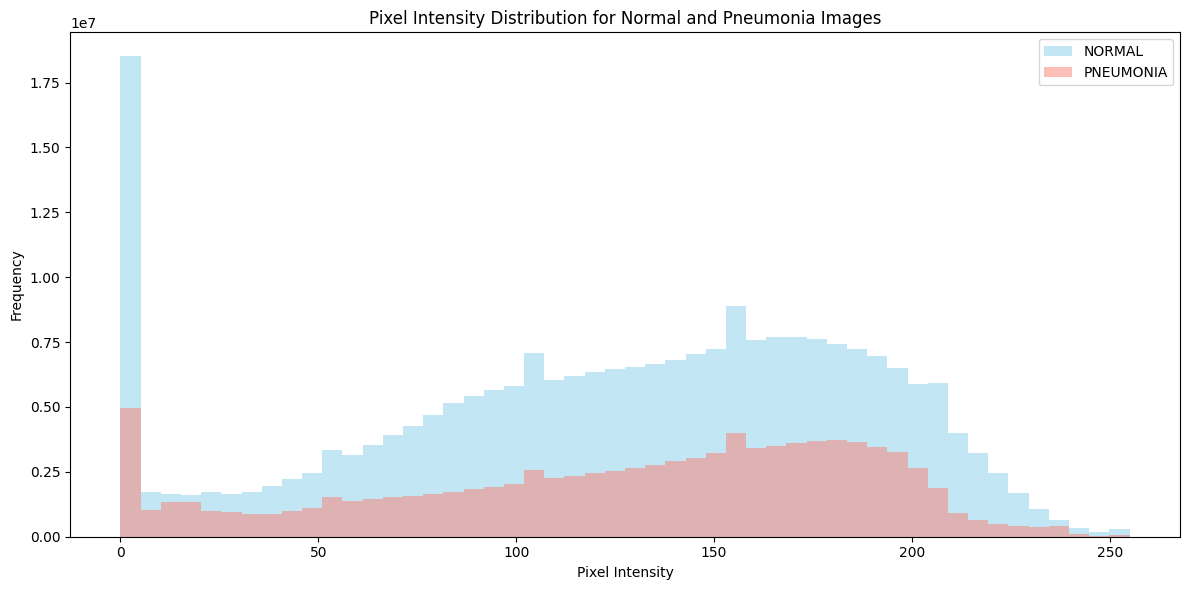

In [9]:
# Function to extract pixel data from sample images
def extract_pixel_data(directory, class_name, sample_size=100):
    class_dir = os.path.join(directory, class_name)
    image_paths = [os.path.join(class_dir, fname) for fname in os.listdir(class_dir)]
    pixel_values = []
    
    for img_path in image_paths[:sample_size]:  # Take a subset of images
        with Image.open(img_path) as img:
            img = img.convert('L')  # Convert to grayscale for simplicity
            img_array = np.array(img)  # Convert to numpy array
            pixel_values.append(img_array.flatten())  # Flatten the array into 1D
        
    return np.concatenate(pixel_values)  # Concatenate all pixel values

# Extract pixel data for Normal and Pneumonia
normal_pixel_data = extract_pixel_data(redistributed_train_dir, 'NORMAL')
pneumonia_pixel_data = extract_pixel_data(redistributed_train_dir, 'PNEUMONIA')

# Plot the histograms of pixel values
plt.figure(figsize=(12, 6))

# Plot histogram for NORMAL class
plt.hist(normal_pixel_data, bins=50, alpha=0.5, label='NORMAL', color='skyblue')

# Plot histogram for PNEUMONIA class
plt.hist(pneumonia_pixel_data, bins=50, alpha=0.5, label='PNEUMONIA', color='salmon')

# Adding labels and title
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.title('Pixel Intensity Distribution for Normal and Pneumonia Images')
plt.legend(loc='upper right')

# Show the plot
plt.tight_layout()
plt.show()

### we will extract pixel values from a few sample images from each class, then plot their pixel intensity distributions.. The histograms represent the distribution of pixel intensities across the images in each class. A higher intensity (closer to 255) indicates a brighter pixel, while lower values (closer to 0) represent darker pixels.

### The NORMAL images have a sharp peak in the lower pixel intensity range (around 0–50), which suggests that most of the pixels in these images are very dark (low intensity). This likely reflects the air in the lungs, which appears black in X-ray images. The distribution also shows some pixels with higher intensities (shifting toward the 100–150 range), which could correspond to bones, tissues, and other structures that are slightly brighter than air.

### The PNEUMONIA images have a broader distribution, with higher frequencies in the mid to higher pixel intensity range (around 50–150). This indicates that there are more variations in pixel intensity in PNEUMONIA images. This suggests that PNEUMONIA images often contain more areas of consolidation, infection, or inflammation, which may appear lighter (higher pixel intensity) than healthy lung tissue (air).

### There's significant overlap in pixel intensity distributions between the two classes, indicating that there is some similarity in pixel values, but the PNEUMONIA distribution tends to shift toward higher pixel intensities overall, likely due to the presence of inflammation and infection within the lungs.

### The class imbalance is apparent, with the "PNEUMONIA" class being the dominant one.¶

### 3 methods to correct class imbalance:
- ** Over sample under sample **- Cannot over or under sample because we have image data. (SMOTE- synthetic minority over sampling technique)
- Assigning Class weights (Class Weights ensure that the minority class is not ignored by the model. It assigns higher importance to the underrepresented class by adjusting the loss function to penalize incorrect predictions on the minority class more heavily.)
- Data Augmentation- Applying data augmentation techniques (such as rotations, flips, shifts, etc.) can help to increase the size of the minority class while maintaining diversity in the data. In the context of chest X-ray images might not be ideal. Applying random transformations (e.g., rotation, zoom, flipping) to the "PNEUMONIA" class might alter the essential features that help identify pneumonia, leading to potentially unrealistic or misleading data. For instance, rotating or flipping a pneumonia image might change its appearance in a way that does not reflect real-life variations of pneumonia.

### we apply the class weights during modelling.

### Data Transformation:
Normalization (or rescaling) should be applied before data augmentation. The reason is that normalization ensures your pixel values are on a consistent scale, which is crucial for model convergence. Neural networks typically perform better when input data is normalized. Normalizing pixel values to a range of [0, 1] ensures the data fed into the model has consistent scales, making training easier and faster.
### 

Data Augmentat: ion
Data augmentation should be applied after normalization. The reason is that augmentation applies transformations to the image, and it's better to apply these transformations to already normalized images so that the augmented data also follows the same format as the original data. Augmentation artificially increases the diversity of your training data by applying various transformations (rotation, flip, zoom, etc.), helping your model generalize better. Augmentation can help improve the model's performance by creating more diverse samples for the minority class.

For training data, we use data augmentation parameters such as rotation, zoom, shifts, and flips, to artificially increase the diversity of the training dataset. The images are also normalized by scaling the pixel values to the range [0, 1] using rescale=1.0/255.0. For validation and test data, we only apply normalization (rescale=1.0/255.0) since we don’t want to augment these sets.

## 5. Data Transformation and Augmentation

#### <b> 5.1. Data Augmentation and DataLoader Setup for Training, Validation, and Testing

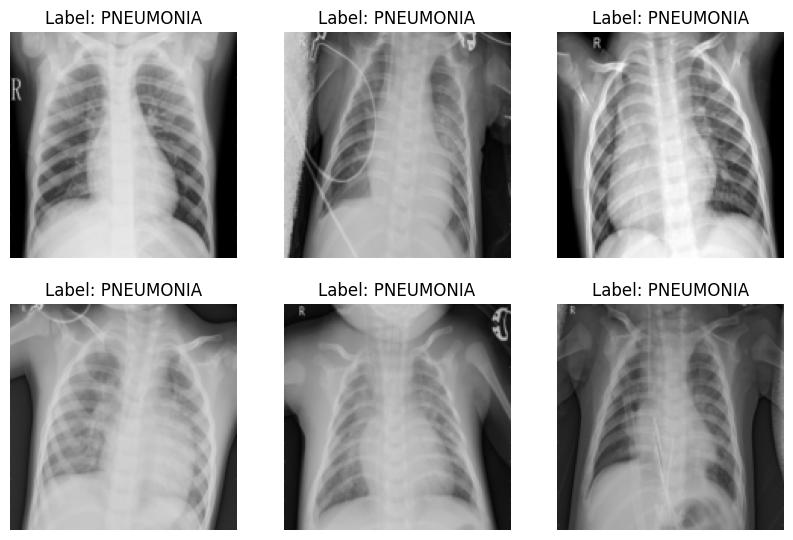

In [ ]:
train_transforms = transforms.Compose([
    transforms.Resize((150, 150)),  # Resize images
    transforms.Grayscale(num_output_channels=3),  # Convert grayscale to 3 channels
    # transforms.RandomRotation(40),  # Random rotations ##dont 
    # transforms.RandomHorizontalFlip(),  # Random horizontal flip ##dont do
    # transforms.RandomAffine(degrees=0, shear=20, translate=(0.2, 0.2), scale=(0.8, 1.2)),  # Shear, shift, zoom
    transforms.ToTensor(),  # Convert image to Tensor
    transforms.Normalize([0.5], [0.5])  # Normalize to [-1, 1]
])

# For test and validation set, we use only conversion to 3 channels and normalization
val_test_transforms = transforms.Compose([
    transforms.Resize((150, 150)),  # Resize images
    transforms.Grayscale(num_output_channels=3),  # Convert grayscale to 3 channels
    transforms.ToTensor(),  # Convert image to Tensor
    transforms.Normalize([0.5], [0.5])  # Normalize to [-1, 1]
])


# Load datasets
train_dataset = datasets.ImageFolder(root=redistributed_train_dir, transform=train_transforms)
val_dataset = datasets.ImageFolder(root=redistributed_val_dir, transform=val_test_transforms)
test_dataset = datasets.ImageFolder(root=redistributed_test_dir, transform=val_test_transforms)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


# Display a few augmented images
def display_augmented_images(data_loader, class_names, num_images=6):
    # Get a batch of images
    images, labels = next(iter(data_loader))
    
    # Denormalize images for visualization
    images = images / 2 + 0.5  # Convert from [-1, 1] to [0, 1]

    # Plot a few images
    plt.figure(figsize=(10, 10))
    for i in range(num_images):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].permute(1, 2, 0))  # Convert CHW to HWC
        plt.axis('off')
        plt.title(f"Label: {class_names[labels[i]]}")
    plt.show()

# Class names for the labels
class_names = train_dataset.classes  # ['NORMAL', 'PNEUMONIA']

# Display augmented images from the training set
display_augmented_images(train_loader, class_names, num_images=6)

#### <b> 5.2.1 Checking Image Dimensions After Transformations (train_loader)

In [11]:
# Function to print image dimensions after transformation (Resizing, etc.)
def print_image_dimensions_after_transformation(data_loader):
    # Get a batch of transformed images
    images, _ = next(iter(data_loader))

    # Print the shape of the images in the batch (C x H x W)
    print(f"Shape of one batch of images: {images.shape}")
    print(f"Number of images in the batch: {images.shape[0]}")
    print(f"Image dimensions (C x H x W): {images.shape[1]} x {images.shape[2]} x {images.shape[3]}")

# Print dimensions of the images after transformation for the training set
print_image_dimensions_after_transformation(train_loader)

Shape of one batch of images: torch.Size([32, 3, 150, 150])
Number of images in the batch: 32
Image dimensions (C x H x W): 3 x 150 x 150


### 150x150 is often chosen because it provides a good balance between computational efficiency and retaining meaningful information in the images. 150x150 is a moderate choice for many models, balancing both speed and accuracy.

### Smaller sizes (e.g., 64x64, 128x128) would reduce the number of pixels and might miss some important details, especially in medical imaging, where textures and patterns could be crucial for classification.

### Larger sizes (e.g., 224x224, 256x256) might retain more details, but they require more memory and computational power, slowing down the training process and potentially leading to overfitting if not managed properly.¶

#### <b> 5.2.2 Checking Image Dimensions After Transformations (test_loader)

In [12]:
# Print dimensions of the images after transformation for the training set
print_image_dimensions_after_transformation(test_loader)

Shape of one batch of images: torch.Size([32, 3, 150, 150])
Number of images in the batch: 32
Image dimensions (C x H x W): 3 x 150 x 150


#### <b> 5.2.3 Checking Image Dimensions After Transformations (val_loader)

In [13]:
# Print dimensions of the images after transformation for the training set
print_image_dimensions_after_transformation(val_loader)

Shape of one batch of images: torch.Size([32, 3, 150, 150])
Number of images in the batch: 32
Image dimensions (C x H x W): 3 x 150 x 150


#### <b> 5.3. Calculating Class Weights for Imbalanced Dataset

In [15]:
# Calculate class weights for the imbalance
class_counts = {'NORMAL': 1108, 'PNEUMONIA': 2991}  # Train class distribution
class_labels = ['NORMAL', 'PNEUMONIA']

# Compute class weights using sklearn's compute_class_weight method
class_weights = compute_class_weight(class_weight='balanced', classes=[0, 1], y=np.array([0] * class_counts['NORMAL'] + [1] * class_counts['PNEUMONIA']))
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).cuda()

# Print out the class weights
print(f"Class weights: {class_weights_tensor}")

Class weights: tensor([1.8497, 0.6852], device='cuda:0')


## 6. CNN model implementation

#### <b> 6.1 CNN Model

In [16]:
# Define the CNN model
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(128 * 18 * 18, 512)  # Flattened layer
        self.fc2 = nn.Linear(512, 2)  # Output layer for binary classification
        self.dropout = nn.Dropout(0.5)
    
    def forward(self, x):
        x = self.conv1(x)
        x = nn.ReLU()(x)
        x = nn.MaxPool2d(2)(x)
        
        x = self.conv2(x)
        x = nn.ReLU()(x)
        x = nn.MaxPool2d(2)(x)
        
        x = self.conv3(x)
        x = nn.ReLU()(x)
        x = nn.MaxPool2d(2)(x)
        
        x = x.view(x.size(0), -1)  # Flatten the output
        x = self.fc1(x)
        x = nn.ReLU()(x)
        x = self.dropout(x)
        
        x = self.fc2(x)
        return x

In [17]:
# Initialize the model
model = CNNModel().cuda()

# Use CrossEntropyLoss for multi-class classification (binary classification with 2 classes)
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)  # Use class weights for imbalanced data
optimizer = optim.Adam(model.parameters(), lr=0.001)

Hyperparameter Tuning
Hyperparameter tuning can be done using various methods, but one of the most common and efficient methods is Grid Search or Random Search. Given that grid search can be computationally expensive, I'll show an example using RandomizedSearchCV for tuning hyperparameters like learning rate and batch size. This method is more efficient as it randomly samples combinations of hyperparameters.

Here’s a code snippet for RandomizedSearchCV using the sklearn library, combined with your model and training function.

The validation accuracy is what matters when selecting the best hyperparameters. This metric reflects how well the model generalizes to unseen data (i.e., how it performs on the validation set that was not used during training).

#### <b> 6.2 Hyperparameter Tuning with Grid Search for CNN Training

In [20]:
# Define the hyperparameters to tune
param_dist = {
    'lr': [0.001, 0.01],  # Learning rates
    'batch_size': [16, 32, 64],  # Batch sizes
    'num_epochs': [10, 20, 30]  # Number of epochs
}

# Utility function to calculate accuracy
def calculate_accuracy(outputs, labels):
    """
    Calculate accuracy given model outputs and true labels.

    Args:
        outputs (torch.Tensor): Model logits.
        labels (torch.Tensor): Ground truth labels.

    Returns:
        float: Accuracy percentage.
    """
    _, preds = torch.max(outputs, dim=1)
    correct = torch.sum(preds == labels).item()
    total = labels.size(0)
    return correct / total


# Train and evaluate model
def train_evaluate_model(lr, batch_size, num_epochs, save_model=True):
    """
    Train and evaluate the model for given hyperparameters.

    Args:
        lr (float): Learning rate.
        batch_size (int): Batch size.
        num_epochs (int): Number of epochs.
        save_model (bool): Whether to save the best model.

    Returns:
        tuple: Best validation accuracy, training accuracies/losses, validation accuracies/losses.
    """
    # Create DataLoaders
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # Initialize model, optimizer, and loss function
    model = CNNModel().cuda()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)

    best_val_acc = 0.0
    train_accs, val_accs = [], []
    train_losses, val_losses = [], []

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss, train_acc = 0.0, 0.0
        for images, labels in train_loader:
            images, labels = images.cuda(), labels.cuda()

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            train_acc += calculate_accuracy(outputs, labels)

        avg_train_loss = train_loss / len(train_loader)
        avg_train_acc = train_acc / len(train_loader)

        # Validation phase
        model.eval()
        val_loss, val_acc = 0.0, 0.0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.cuda(), labels.cuda()
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                val_acc += calculate_accuracy(outputs, labels)

        avg_val_loss = val_loss / len(val_loader)
        avg_val_acc = val_acc / len(val_loader)

        # Save best model
        if save_model and avg_val_acc > best_val_acc:
            best_val_acc = avg_val_acc
            model_save_path = f"best_model_lr_{lr}_batch_{batch_size}_epochs_{num_epochs}.pth"
            torch.save(model.state_dict(), model_save_path)
            print(f"Epoch {epoch+1}/{num_epochs} - Saved Best Model to {model_save_path} with Val Accuracy: {best_val_acc:.4f}")

        # Log epoch results
        print(f"Epoch {epoch+1}/{num_epochs} - "
              f"Train Loss: {avg_train_loss:.4f}, Train Accuracy: {avg_train_acc:.4f}, "
              f"Val Loss: {avg_val_loss:.4f}, Val Accuracy: {avg_val_acc:.4f}")

        # Append results for analysis
        train_accs.append(avg_train_acc)
        val_accs.append(avg_val_acc)
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)

    return best_val_acc, train_accs, val_accs, train_losses, val_losses


# Grid search for hyperparameter tuning
best_val_acc = 0.0
best_params = None

for lr in param_dist['lr']:
    for batch_size in param_dist['batch_size']:
        for num_epochs in param_dist['num_epochs']:
            print(f"Starting training with lr={lr}, batch_size={batch_size}, num_epochs={num_epochs}")
            val_acc, train_accs, val_accs, train_losses, val_losses = train_evaluate_model(lr, batch_size, num_epochs)
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                best_params = {'lr': lr, 'batch_size': batch_size, 'num_epochs': num_epochs}

print(f"Best Validation Accuracy: {best_val_acc:.4f} with parameters: {best_params}")

Starting training with lr=0.001, batch_size=16, num_epochs=10
Epoch 1/10 - Saved Best Model to best_model_lr_0.001_batch_16_epochs_10.pth with Val Accuracy: 0.9352
Epoch 1/10 - Train Loss: 0.3182, Train Accuracy: 0.8731, Val Loss: 0.1572, Val Accuracy: 0.9352
Epoch 2/10 - Saved Best Model to best_model_lr_0.001_batch_16_epochs_10.pth with Val Accuracy: 0.9557
Epoch 2/10 - Train Loss: 0.1752, Train Accuracy: 0.9387, Val Loss: 0.1373, Val Accuracy: 0.9557
Epoch 3/10 - Train Loss: 0.1458, Train Accuracy: 0.9450, Val Loss: 0.1255, Val Accuracy: 0.9489
Epoch 4/10 - Saved Best Model to best_model_lr_0.001_batch_16_epochs_10.pth with Val Accuracy: 0.9580
Epoch 4/10 - Train Loss: 0.1286, Train Accuracy: 0.9509, Val Loss: 0.1192, Val Accuracy: 0.9580
Epoch 5/10 - Saved Best Model to best_model_lr_0.001_batch_16_epochs_10.pth with Val Accuracy: 0.9614
Epoch 5/10 - Train Loss: 0.1030, Train Accuracy: 0.9643, Val Loss: 0.1240, Val Accuracy: 0.9614
Epoch 6/10 - Saved Best Model to best_model_lr_0.0

#### <b> 6.3. Final Training with Best Hyperparameters

In [21]:
# Final training with best hyperparameters
print(f"Final training with best parameters: {best_params}")
final_val_acc, _, _, _, _ = train_evaluate_model(
    lr=best_params['lr'],
    batch_size=best_params['batch_size'],
    num_epochs=best_params['num_epochs'],
    save_model=False  # Don't overwrite the best model during final training
)
print(f"Final model trained with best parameters: {best_params} and Validation Accuracy: {final_val_acc:.4f}")

Final training with best parameters: {'lr': 0.001, 'batch_size': 32, 'num_epochs': 30}
Epoch 1/30 - Train Loss: 0.2884, Train Accuracy: 0.8736, Val Loss: 0.1414, Val Accuracy: 0.9531
Epoch 2/30 - Train Loss: 0.1778, Train Accuracy: 0.9368, Val Loss: 0.1205, Val Accuracy: 0.9621
Epoch 3/30 - Train Loss: 0.1404, Train Accuracy: 0.9518, Val Loss: 0.1127, Val Accuracy: 0.9598
Epoch 4/30 - Train Loss: 0.1159, Train Accuracy: 0.9547, Val Loss: 0.1285, Val Accuracy: 0.9531
Epoch 5/30 - Train Loss: 0.1022, Train Accuracy: 0.9625, Val Loss: 0.1551, Val Accuracy: 0.9420
Epoch 6/30 - Train Loss: 0.0811, Train Accuracy: 0.9692, Val Loss: 0.1343, Val Accuracy: 0.9450
Epoch 7/30 - Train Loss: 0.0691, Train Accuracy: 0.9784, Val Loss: 0.1191, Val Accuracy: 0.9598
Epoch 8/30 - Train Loss: 0.0585, Train Accuracy: 0.9799, Val Loss: 0.1277, Val Accuracy: 0.9665
Epoch 9/30 - Train Loss: 0.0428, Train Accuracy: 0.9843, Val Loss: 0.1227, Val Accuracy: 0.9665
Epoch 10/30 - Train Loss: 0.0257, Train Accuracy:

### After completing the grid search, the code stores the hyperparameter combination that gave the best validation accuracy (best_val_acc) and the corresponding hyperparameters in best_params.

#### <b> 6.4. # Loading and Saving the Final Best Model

In [22]:
# Load the best model after grid search
best_model_path = f"best_model_lr_{best_params['lr']}_batch_{best_params['batch_size']}_epochs_{best_params['num_epochs']}.pth"
final_model = CNNModel().cuda()  # Ensure the model is initialized
final_model.load_state_dict(torch.load(best_model_path))

# Save the final best model
torch.save(final_model.state_dict(), "/kaggle/working/best_model.pth")
print(f"Final best model saved to /kaggle/working/best_model.pth")

# # Save the best model during training (if validation accuracy improves)
# torch.save(final_model.state_dict(), "/kaggle/working/best_model.pth")

/tmp/ipykernel_30/3309605205.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  final_model.load_state_dict(torch.load(best_model_path))


Final best model saved to /kaggle/working/best_model.pth


## 7. Loading the Best Model for Inference

In [23]:
# Load the best model for inference
model = CNNModel().cuda()  # Make sure the model architecture matches the one used during training
model.load_state_dict(torch.load("best_model.pth"))
model.eval()  # Set the model to evaluation mode

/tmp/ipykernel_30/3425594651.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pth"))


CNNModel(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=41472, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=2, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

## 8. Testing the Final Model and Visualizing Predictions

/tmp/ipykernel_30/1003064109.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  final_model.load_state_dict(torch.load("best_model.pth"))


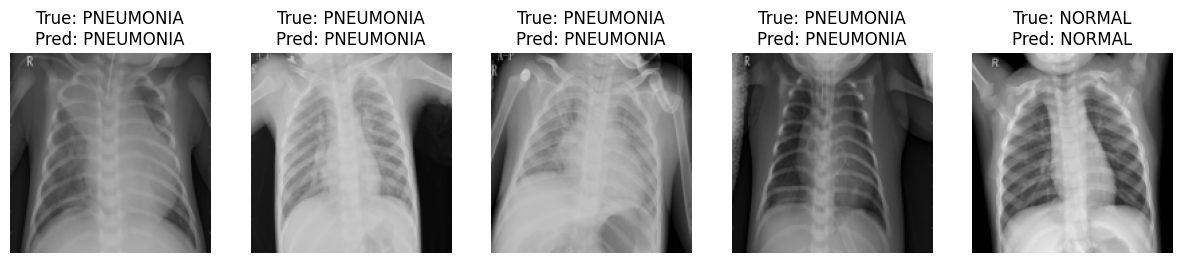

              precision    recall  f1-score   support

      NORMAL       0.93      0.94      0.94       238
   PNEUMONIA       0.98      0.98      0.98       641

    accuracy                           0.97       879
   macro avg       0.96      0.96      0.96       879
weighted avg       0.97      0.97      0.97       879



In [25]:
# Assuming 'best_params' is obtained from hyperparameter tuning (with best lr, batch_size, num_epochs)
best_lr = best_params['lr']
best_batch_size = best_params['batch_size']
best_num_epochs = best_params['num_epochs']

# Reinitialize the model with the best parameters
final_model = CNNModel().cuda()

# Load the best model weights (assumes best model was saved during training)
final_model.load_state_dict(torch.load("best_model.pth"))

# Test DataLoader with the best batch size
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=best_batch_size, shuffle=False)

# Store predictions and true labels
all_preds = []
all_labels = []

# Define the mean and std used for normalization
mean = [0.5, 0.5, 0.5]  # Adjust these values to the ones used during normalization
std = [0.5, 0.5, 0.5]

# Function to denormalize images
def denormalize(image, mean, std):
    mean = torch.tensor(mean).view(1, 3, 1, 1)  # Reshape for broadcasting
    std = torch.tensor(std).view(1, 3, 1, 1)
    return image * std + mean

# Make predictions on the test set
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.cuda(), labels.cuda()

        # Denormalize the images for visualization
        denorm_images = denormalize(images.cpu(), mean, std)

        # Get the model predictions
        outputs = final_model(images)
        _, predicted = torch.max(outputs, 1)  # Get predicted class

        # Store predictions and true labels
        all_preds.extend(predicted.cpu().numpy())  # Convert to CPU for storing
        all_labels.extend(labels.cpu().numpy())

# Display some images with predictions
def show_images(images, labels, predictions, class_names):
    fig, axes = plt.subplots(1, 5, figsize=(15, 3))
    for i in range(5):
        ax = axes[i]
        ax.imshow(images[i].permute(1, 2, 0))  # Convert back to HxWxC format for displaying
        ax.set_title(f"True: {class_names[labels[i]]}\nPred: {class_names[predictions[i]]}")
        ax.axis('off')
    plt.show()

# Show 5 random test images with predictions
import random
indices = random.sample(range(len(test_dataset)), 5)
images, labels = zip(*[test_dataset[i] for i in indices])
images = torch.stack(images)

# Denormalize the images for display
images = denormalize(images, mean, std)

# Convert all_preds to a list of predictions for the selected images
predictions = [all_preds[i] for i in indices]

# Define class names (Binary classification: 'NORMAL' and 'PNEUMONIA')
class_names = ['NORMAL', 'PNEUMONIA']  # These should be your actual class names

# Display images and predictions
show_images(images, labels, predictions, class_names)

# Print classification report
print(classification_report(all_labels, all_preds, target_names=class_names))
